In [ ]:
# Mount YOUR google drive. You'll need to "Add shortcut to Drive" for our shared folder for it to show up here.
# Use the URL shown below in the output to authorize this Colab session to access you GDrive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [1]:
# Import needed packages
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats as sts
from scipy.stats import ttest_ind
from numpy.random import default_rng
from plotnine import *
import pandas as pd

import pandas as pd
import geopandas as gpd
import geopy
import geopy.distance
from shapely.geometry import Point, Polygon
import plotly.express as px

In [ ]:
# Read the shapefile
gdf_census = gpd.read_file("New folder\GTA_Census.shp")
gdf_census.crs = 'EPSG:3347' #Canada Geodetic National 3-degree (NAD83)

'''
These data represent census tracts (subdivisions of a city) in the
Greater Toronto Area (GTA). For each census tract, we have data on the *median*
household income in 2015 (HInc2015), in 2020 (HInc2020), and the 'delta'
between 2020 and 2015 (DHInc) - positive values represent increases in the
median household income in that census tract.
'''

gdf_census.head(3)

,CTUID,DGUID,HInc2020,HInc2015,DHInc,geometry
0,5350420.13,2021S05075350420.13,75500,81000,-5500,"POLYGON ((7218613.794 949619.114, 7218679.703 ..."
1,5350422.03,2021S05075350422.03,111000,128000,-17000,"POLYGON ((7219855.811 954804.291, 7219916.443 ..."
2,5350422.04,2021S05075350422.04,112000,119000,-7000,"POLYGON ((7217958.14 954705.514, 7217957.497 9..."


In [ ]:
# Some important things about this dataframe
'''
The 'geometry' column contains polygons objects (i.e., the coordinates of each their vertices).
These polygon have a centroid and area which will use later!!!
This column allow us to plot these data on a map.
'''

# We will add a column with the centroid of each polygon
gdf_census['Centroids'] = gdf_census['geometry'].centroid

# Calculate the distance from each point to downtown Toronto
# You can calculate the distance between Point1(x1,y1) and Point2(x2,y2) as
# Point1.distance(Point2)
# The points are given in UTM coordinates, the calculated distances will be in metres.
'''
For this problem you will consider this point as representing Downtown Toronto:
 Point([7224162.76,930275.15])
'''
gdf_census['DistanceToDowntown'] = gdf_census['Centroids'].distance(Point([7224162.76,930275.15]))


# Transform into a geodataframe for plotting
gdf_plt = gpd.GeoDataFrame(gdf_census)

# shape file is a different CRS, change to lon/lat GPS co-ordinates
gdf_plt = gdf_plt.to_crs("WGS84")


# Plot
fig = px.choropleth_mapbox(
    gdf_plt,
    geojson=gdf_plt.geometry, # This line is telling the map which column contains the geometry information
    locations=gdf_plt.index,
    color="HInc2020",
    labels={'HInc2020':'Household Income in 2020'},
    color_continuous_scale="Sunset",
    center=dict(lat=43.615, lon=-79.4653),
    mapbox_style="open-street-map",
    opacity=0.9,
    zoom=8, # I changed them
    height=1000,
    width=800
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.



---



---



## <font color='orange'> Main </font>

In this problem, you will assess whether proximity to Downtown Toronto influences median household income in a Census tract.

In [ ]:
# Write down the null hypothesis (H0) and
# the alternative hypothesis (H1) for this problem.

**H0** = there is no relation between distance to downtown toronto and median houshold income  
**H1** = there is a significant relation between distance to downtown toronto and median houshold income

Rodrigo:  
Hypothesis testing is about statistically significant differences, and that wording is important in technical communication. It is not about correlations, it is not about (just) differences, and it is not about (just) significant differences. H0 should be 'distance to downtown does not lead to statistically significant differences in household income in Toronto'.




---



---



## <font color='orange'> Task 2 - Identify which census tracts are "near" or "far" from downtown Toronto. </font>

In [ ]:
# For each census tract, determine if its distance to Downtown Toronto is
# less or more than the *median* distance for all census tracts.
# If it is less or equal, set the census tract as being 'close' to Downtown Toronto.
# If it is more, set the census tract as being 'far' to Downtown Toronto.
# I suggest creating new columns in your dataframe to store this information.

In [ ]:
#gdf_plt.shape : (1218, 8)
#gdf_plt.columns : ['CTUID', 'DGUID', 'HInc2020', 'HInc2015', 'DHInc', 'geometry','Centroids', 'DistanceToDowntown']
median_distance = gdf_plt['DistanceToDowntown'].median() #20144.973620004228
gdf_plt['proximity'] = gdf_plt['DistanceToDowntown'].apply(lambda row: 'close' if row <= median_distance else 'far')
gdf_plt.head(3)

,CTUID,DGUID,HInc2020,HInc2015,DHInc,geometry,Centroids,DistanceToDowntown,proximity
0,5350420.13,2021S05075350420.13,75500,81000,-5500,"POLYGON ((-79.40757 43.84423, -79.40717 43.842...",POINT (7217732.637 949177.807),19966.394906,close
1,5350422.03,2021S05075350422.03,111000,128000,-17000,"POLYGON ((-79.38047 43.88684, -79.38012 43.885...",POINT (7218597.14 955095.584),25436.785460,far
2,5350422.04,2021S05075350422.04,112000,119000,-7000,"POLYGON ((-79.40335 43.88924, -79.40336 43.889...",POINT (7218402.76 954189.238),24597.991428,far


## <font color='orange'> Task 3 - Assess spatial differences in median household income as a function of distance from Downtown Toronto. </font>

In [ ]:
# Building on what you learned about Descriptive Statisics,
# Use plots and data summaries to try to determine whether income and
# distance to downtown are correlated.

# There is not one single correct way to do this.

In [ ]:
descriptive_stats = gdf_plt[['DistanceToDowntown', 'HInc2020']].describe()
descriptive_stats
#it is abnormal that min income for some households is 0.

,DistanceToDowntown,HInc2020
count,1218.000000,1218.000000
mean,21660.466339,92434.318555
std,14129.809348,34785.420230
min,0.010842,0.000000
25%,10718.002137,68500.000000
50%,20144.973620,90000.000000
75%,30911.420904,112000.000000
max,81767.353684,314000.000000


The mean distance to Downtown is around 21,660 meters (21.66 km), with a large standard deviation of 14,129 meters. This suggests that census tracts are spread over a wide area, with some far from downtown.  
it is abnormal that min income for some households is 0. The median income is $90,000, meaning half of the census tracts have a household income below this amount, and half are above.  
based on descriptive statistics alone, it is not possible to determine whether proximity to downtown significantly influences household income or not. Let me check scatter plot to visulize them.

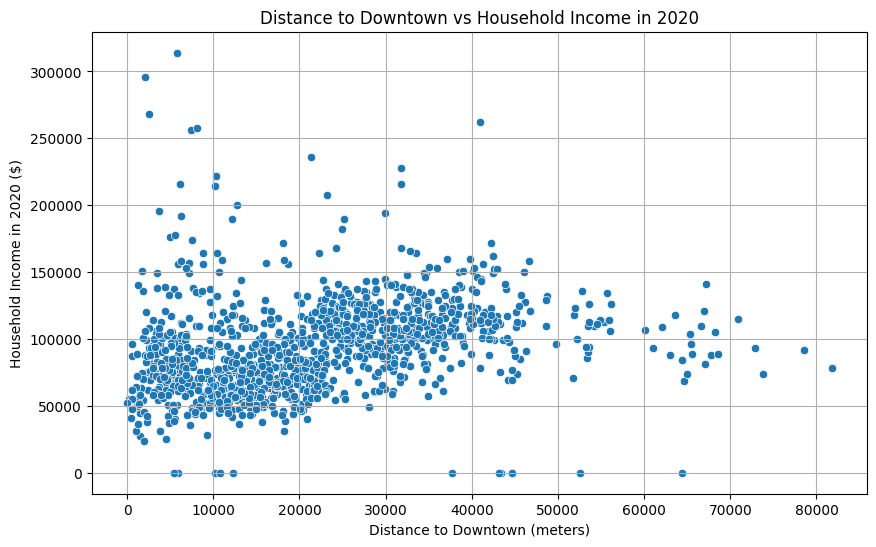

In [ ]:
import seaborn as sns
plt.figure(figsize =(10,6))
sns.scatterplot(x='DistanceToDowntown', y='HInc2020', data=gdf_plt)
plt.title('Distance to Downtown vs Household Income in 2020')
plt.xlabel('Distance to Downtown (meters)')
plt.ylabel('Household Income in 2020 ($)')
plt.grid(True)
plt.show()

Most of points are in distance range of 0-40km from down town. Some high-income census tracts are close to downtown, but also observed high income in greater distance. Therefore, there is no strong visible correlation between them. Points are scattered, indicating that distance may not directly predict household income.

correlation between income and distance to downtown is 0.28597269474283443


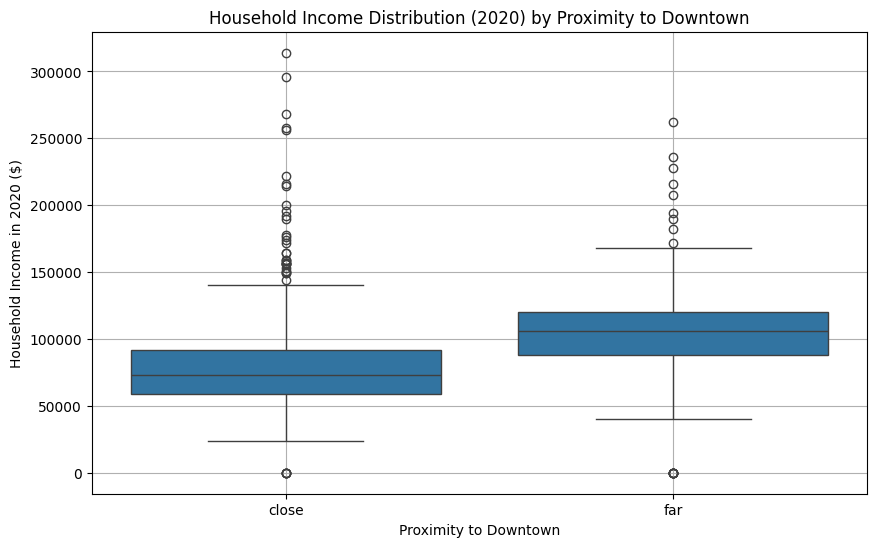

In [ ]:
# Calculate the Pearson correlation coefficient
correlation = gdf_plt['DistanceToDowntown'].corr(gdf_plt['HInc2020'])
print(f"correlation between income and distance to downtown is {correlation}")
# Box plot to compare income distributions for 'close' and 'far' tracts
plt.figure(figsize=(10, 6))
sns.boxplot(x='proximity', y='HInc2020', data=gdf_plt)
plt.title('Household Income Distribution (2020) by Proximity to Downtown')
plt.xlabel('Proximity to Downtown')
plt.ylabel('Household Income in 2020 ($)')
plt.grid(True)
plt.show()

In [ ]:
# Q: what is initial guess based on the visual analysis?
# Do you believe there is a significant spatial difference in median household income?

The correlation between Distance to Downtown Toronto and Household Income in 2020 is 0.286. This indicates a weak positive correlation, suggesting that as the distance from downtown increases, the household income tends to increase slightly.  
Median income for census tracts closer to downtown is slightly lower compared to those farther away. but there is a broader range of income for those closer to downtown.  
From scatter plot, box plot, weak correlation, I think there is no strong realtionship between distance to downtown and Income. there are a considerable overlap in income between two groups (close/ far) and median income are slightly different.
to check it more accurately, other statistical test such as t-test or ANOVA can be able to determine that it is statistically significant or not.



---



---



## <font color='orange'> Task 4 - Conduct a Welch's t test for the mean. </font>

In [ ]:
# Conduct a Welch's t test for the mean to assess whether distance from Downtown
# meaningfully impact (i.e., is statistically significant) median household income.
# Perform the calculations without using built-in functions.


# Here goes your calculations to determine the t_statistic
# The code below will help you get the t-critical/p-value without having to manually
# consult a T-test table


# Calculate the p-value from a t distribution for a two tail-test
# T-test table
# https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf

##Group 1: Tracts that are 'close' to downtown.
##Group 2: Tracts that are 'far' from downtown.

from scipy.stats import t

data_close = gdf_plt[gdf_plt['proximity'] == 'close']
mean_close = data_close['HInc2020'].mean()
s_close = data_close['HInc2020'].std()
n_close = len(data_close)

data_far = gdf_plt[gdf_plt['proximity'] == 'far']
mean_far = data_far['HInc2020'].mean()
s_far = data_far['HInc2020'].std()
n_far = len(data_far)

SE = np.sqrt((s_close**2/n_close)+ (s_far**2/n_far))
t_statistic = np.abs(mean_close-mean_far)/ SE
#t-value, degrees of freedom
print('Manual t-statistic:', t_statistic, ', Manual p-value:', 2*(1-t.cdf(t_statistic,gdf_census.shape[0]-1)))
# **I googled and notice there is another formulation for df of Welch's t-test** however, I used what you prepared!
#df = ((s_close**2 / n_close) + (s_far**2 / n_far))**2 / (((s_close**2 / n_close)**2 / (n_close - 1)) + ((s_far**2 / n_far)**2 / (n_far - 1))) # => 1177.391336054504


# Results using built-in function for comparison
import scipy.stats as stats
print('Built-in t-statistic, Built-in p-value:', stats.ttest_ind(data_far['HInc2020'], data_close['HInc2020'], equal_var = False))

Manual t-statistic: 12.85221201206699 , Manual p-value: 0.0
Built-in t-statistic, Built-in p-value: TtestResult(statistic=12.852212012066994, pvalue=1.792782931479039e-35, df=1177.391336054504)


Manual t_statistic = 12.85, it is large (is > t_critical) , indicating that two groups' income (close/far) are significantly different.  
Manual p_value = 0, which means we reject the H0. Therefore, difference in household income between those clos and far from downtown is statistically significant.  
In summary, There is a significant spatial difference in household income between two groups!

In [ ]:
#n_far #609
#n_close #609
#mean_far #104458.94909688013
#mean_close #80409.68801313629

## <font color='orange'> Task 5 - Assess whether distance from Downtown affects median household income using permutation test. </font>

In [ ]:
# a. Use a permutation test with 1,000 permutations
# to decide whether H0 can be accepted or rejected.
# Justify your decision based on the calculated p-value.
# Present as many steps of the calculation as you believe are necessary.

# As usual, there exist built-in function to circumvent this calculation.
# Do not use built-in functions that would not allow me to evaluate if you
# understand the steps of this process. It is okay to use math/probability functions.

# Required: plot a histogram of the permutations vs original value for
# a. the results for 'far' census tracts (i.e., histogram of permuted 'far' incomes showing mean_far as a line)
# b. the results for 'close' census tracts (i.e., histogram of permuted 'close' incomes showing mean_close as a line)
# c. the results for 'delta' (i.e., histogram of permuted delta showing delta0 as a line, see below)

# Discuss the results for each histogram
## Do the permuted and original values overlap?
## How do you interpret the overlap/lack of overlap?

p_value: 0.0


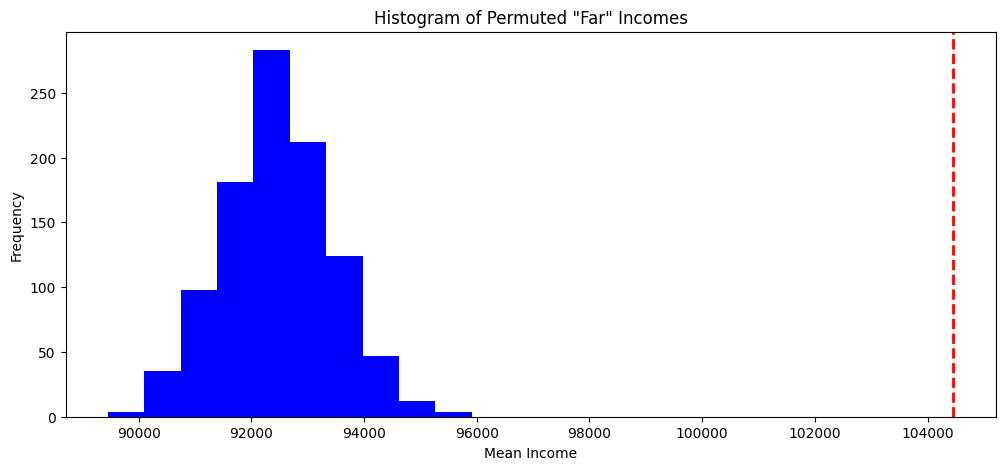

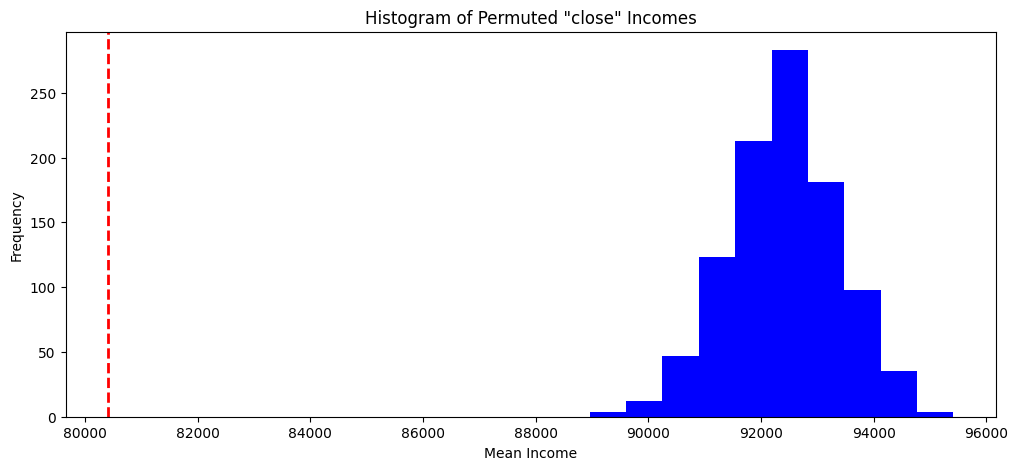

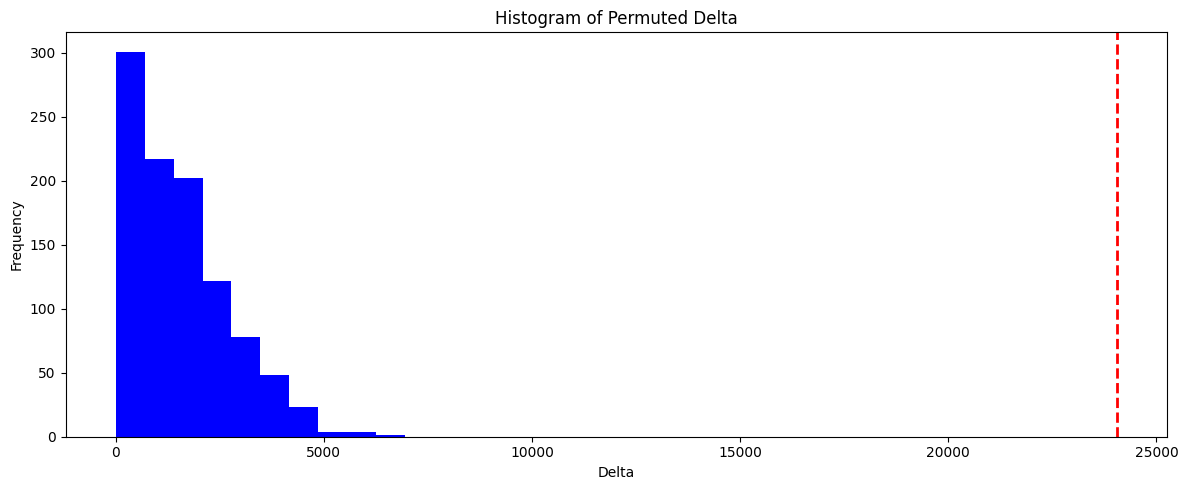

In [ ]:
delta_zero = np.abs(mean_close - mean_far)

permutation_num = 1000
deltas = []
means_close = []
means_far = []

for _ in range(permutation_num):
  # shuffle data
  data = gdf_plt.sample(frac=1).reset_index(drop=True)

  R_a = data[:n_close]
  R_b = data[n_close:]

  mean_ra = R_a['HInc2020'].mean()
  mean_rb = R_b['HInc2020'].mean()
  delta = np.abs(mean_ra - mean_rb)
  #Rodrigo:  'delta0' in the permutation test can be negative. This does not affect your conclusions in this HW but it can be negative because it is a difference (not an income value).

  deltas.append(delta)
  means_close.append(mean_ra)
  means_far.append(mean_rb)

deltas = np.array(deltas)
means_close = np.array(means_close)
means_far = np.array(means_far)

numinator = len(deltas[deltas >= delta_zero])
p_value = numinator / permutation_num
print('p_value:', p_value)

#a
plt.figure(figsize=(12, 5))
plt.hist(means_far, color='blue')
plt.axvline(mean_far, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogram of Permuted "Far" Incomes')
plt.xlabel('Mean Income')
plt.ylabel('Frequency')

#b
plt.figure(figsize=(12, 5))
plt.hist(means_close, color='blue')
plt.axvline(mean_close, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogram of Permuted "close" Incomes')
plt.xlabel('Mean Income')
plt.ylabel('Frequency')

#c
plt.figure(figsize=(12, 5))
plt.hist(deltas, color='blue')
plt.axvline(delta_zero, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogram of Permuted Delta')
plt.xlabel('Delta')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Histogram of permuted "far" incomes:**  
is centered around 92000. the original mean (red dash line) is 104458.9, significantly higher than means of permuted data. Therefore, it suggests that observed difference in "far" incomes is not likely due to random chance.  

**Histogram of permuted "close" incomes:**  
is also centered around 92000 but the original mean (red dash line) is 80409.68801313629 which is much lower than the permuted distribution, suggesting that the actual income for "close" tracts is different from what would be expected under random permutations.    

The lack of overlap between the observed mean and the permuted distribution points towards a significant impact of proximity to downtown on median household income.  

**Histogram pf permuted delta:**  
is skewed left, with most of the values below 5000. the original delta is 24049.26 much larger than range of the permuted distribution. this suggests that observed difference in median of household incomes between two groups is less likely to occure by random chance.

p_value is also 0.0 indicates strong evidence against null hypothesis.This means that the observed difference in median household income between "close" and "far" tracts is statistically significant. therefore, there is a significant impact of proximity to downtown on median household income.



---



## <font color='orange'> Task 6 - Use an ANOVA to assess if the differences in the change in incomes (DHInc) between 5 neighbourhoods is statistically significant at a confidence level of 90%. </font>

In [ ]:
# In the data you have, the column DHInc represents the change (delta) in
# median household income for each Census Tract between 2015 and 2020.
# A positive change means an increase in income.

# In this task, we will use ANOVA to determine whether the changes in income
# in 5 neighbourhoods are signficantly different from each other.

# To simplify things, we will define these neighbourhoods as
# random collections of 120 Census Tracts. Later in the course we will discuss
# how to define the neighbourhoods properly.

# The following code will generate 5 data frames for you, each containing 120
# Census tracts. For example, for neighbourhood 1, gdf_neighbourhood_1['DHInc']
# is the data you will use in the ANOVA.

rng = default_rng(13) # reseting the random number generator to create consistent results
#gdf_census_shuffle = gdf_census.sample(frac=1).reset_index(drop=True)
gdf_census_shuffle = gdf_plt.sample(frac=1, random_state=13).reset_index(drop=True)
gdf_neighbourhood_1 = gdf_census_shuffle.loc[0:119,:].reset_index(drop=True)
gdf_neighbourhood_2 = gdf_census_shuffle.loc[120:239,:].reset_index(drop=True)
gdf_neighbourhood_3 = gdf_census_shuffle.loc[240:359,:].reset_index(drop=True)
gdf_neighbourhood_4 = gdf_census_shuffle.loc[360:479,:].reset_index(drop=True)
gdf_neighbourhood_5 = gdf_census_shuffle.loc[480:599,:].reset_index(drop=True)

In [ ]:
# df = 5*120-5 = 595
#built in function for comparison
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_anova = pd.DataFrame()
df_anova['N1'] = gdf_neighbourhood_1['DHInc']
df_anova['N2'] = gdf_neighbourhood_2['DHInc']
df_anova['N3'] = gdf_neighbourhood_3['DHInc']
df_anova['N4'] = gdf_neighbourhood_4['DHInc']
df_anova['N5'] = gdf_neighbourhood_5['DHInc']

df_anova_long = pd.melt(df_anova)
df_anova_long.rename(columns={"variable": "Neighbourhood", "value": "DHInc",},inplace=True)

model = smf.ols('DHInc ~ Neighbourhood',data=df_anova_long).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Neighbourhood,4.0,8.119159e+08,2.029790e+08,1.077433,0.366749
Residual,595.0,1.120928e+11,1.883912e+08,NaN,NaN


In [ ]:
#My approach:
#determine whether the changes in income in 5 neighbourhoods are signficantly different from each other.
#1. combine all data -> its already done = gdf_plt
#2. shuffle and draw are also done gdf_neighbourhood_1 to gdf_neighbourhood_5
#3. record mean of each 5 groups
#4. record var of each 5 groups
#5. You do not need to use a permutation test. You will calculate one F-value.
num_obs = 120 #for each group
num_group = 5

mean1 = gdf_neighbourhood_1['DHInc'].mean()
mean2 = gdf_neighbourhood_2['DHInc'].mean()
mean3 = gdf_neighbourhood_3['DHInc'].mean()
mean4 = gdf_neighbourhood_4['DHInc'].mean()
mean5 = gdf_neighbourhood_5['DHInc'].mean()


sew1 = np.sum((gdf_neighbourhood_1['DHInc'] - mean1)**2)
sew2 = np.sum((gdf_neighbourhood_2['DHInc']- mean2)**2)
sew3 = np.sum((gdf_neighbourhood_3['DHInc'] - mean3)**2)
sew4 = np.sum((gdf_neighbourhood_4['DHInc'] - mean4)**2)
sew5 = np.sum((gdf_neighbourhood_5['DHInc'] - mean5)**2)
ssw = sew1 + sew2 + sew3 + sew4 + sew5

global_mean = (mean1 + mean2 + mean3 + mean4 + mean5)/ num_group

seb1 = (mean1 - global_mean)**2
seb2 = (mean2 - global_mean)**2
seb3 = (mean3 - global_mean)**2
seb4 = (mean4 - global_mean)**2
seb5 = (mean5 - global_mean)**2
ssb = num_obs * (seb1 + seb2 + seb3 + seb4 + seb5)

df_g = num_group - 1
df0 = 120 * 5 - num_group

ASSB = ssb / df_g
ASSW = ssw / df0

F_statistics = ASSB / ASSW
print('F_statistics :', F_statistics)

F_statistics : 1.077433397407343


Alpha is =  1 - 0.9 = 0.1, df1 = 4, and df2 = 595 -> F_criticals ~  1.94486
therefore, F_statistics =  1.077433397407343 < F_criticals =  1.94486 fail to reject the null hypothesis. At a 90% confidence level, there is no statistically significant difference in the change in incomes (DHInc) between the 5 neighborhoods. This means that, based on the available data and analysis, we do not have enough evidence to conclude that the changes in incomes are significantly different across neighborhoods.

In [ ]:
#If you need the exact value for F_critical, instead of using "infinity"
from scipy.stats import f

# Set the significance level and degrees of freedom
alpha = 0.10
df1 = 4
df2 = 595

# Find the critical value
f_critical = f.ppf(1 - alpha, df1, df2)
print("F-critical value:", f_critical)

F-critical value: 1.9543301609037897




---



---

